In [2]:
# from google.colab import drive
# drive.mount('/content/drive')
# import sys
# sys.path.append('/content/drive/MyDrive/BioMassters/')

In [3]:
%connect_info

{
  "shell_port": 9010,
  "iopub_port": 9012,
  "stdin_port": 9011,
  "control_port": 9009,
  "hb_port": 9008,
  "ip": "127.0.0.1",
  "key": "8a32f221-f1cc-4920-96d3-c28f945e1bc8",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-v2-213326n7jPcLEZEQUb.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.


In [4]:
import tensorflow as tf

import os
import time
import datetime

from matplotlib import pyplot as plt
from IPython import display

2023-06-20 17:06:27.578196: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-20 17:06:27.638674: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [5]:
PATH_TRAIN = '/home/cb/sis/biodata/train_tensors'
PATH_VAL = '/home/cb/sis/biodata/val_tensors'

# The training set consist of 50 images
BUFFER_SIZE = 50
# The batch size of 1 produced better results for the U-Net in the original pix2pix experiment
BATCH_SIZE = 1
# Each image is 256x256 in size
IMG_WIDTH = 256
IMG_HEIGHT = 256

2023-06-20 17:06:36.999951: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


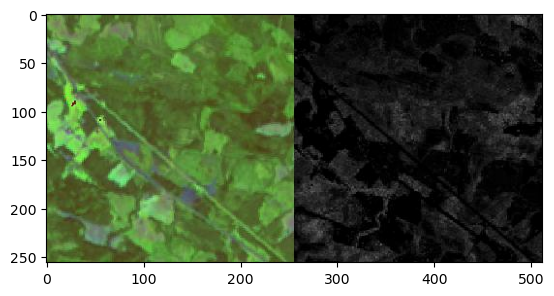

In [6]:
sample_image = tf.io.read_file(str(f'{PATH_TRAIN}/0fd644ae.jpg'))
sample_image = tf.io.decode_jpeg(sample_image)
plt.figure()
plt.imshow(sample_image)

In [7]:
def load(image_file):
  print('load')
  # Read and decode an image file to a uint8 tensor
  image = tf.io.read_file(image_file)
  image = tf.io.decode_jpeg(image)

  # Split each image tensor into two tensors:
  # - one with a real building facade image
  # - one with an architecture label image
  image.set_shape((256,512,3))
  # x = tf.slice(image, [0,0,0], [256,256,3])

  input_images = []
  input_image = image[:, :256, :]
  real_image = image[:, 256:, 0]

  # Convert both images to float32 tensors
  input_image = tf.cast(input_image, tf.float32)
  real_image = tf.cast(real_image, tf.float32)

  return input_image, real_image

load
88.85268
124.38844
56.33673
17.526672


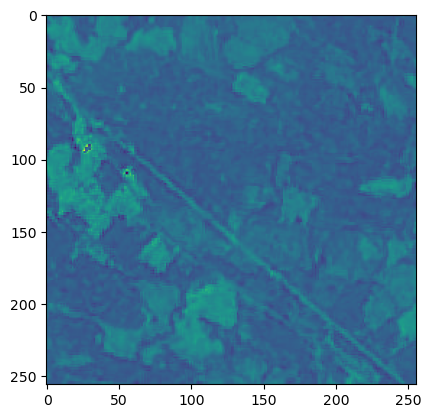

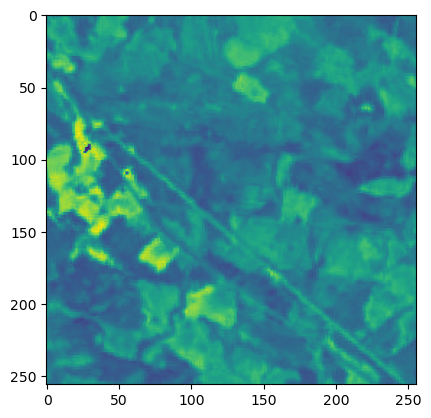

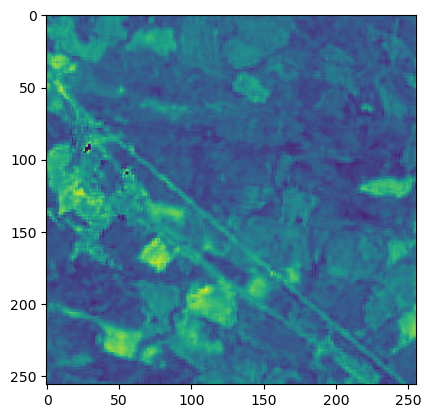

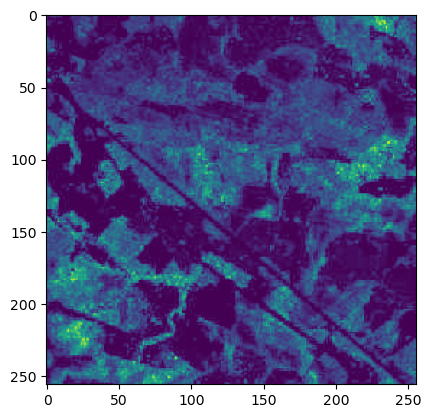

In [8]:
inp, re = load(str(f'{PATH_TRAIN}/0fd644ae.jpg'))
# Casting to int for matplotlib to display the images
print(inp[:,:,0].numpy().mean())
print(inp[:,:,1].numpy().mean())
print(inp[:,:,2].numpy().mean())
print(re.numpy().mean())
plt.figure()
plt.imshow(inp[:,:,0])
plt.figure()
plt.imshow(inp[:,:,1])
plt.figure()
plt.imshow(inp[:,:,2])
plt.figure()
plt.imshow(re)

In [9]:
def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

In [8]:
def resize_one(input_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image

In [9]:
def random_crop(input_image, real_image):
  stacked_image = tf.stack([input_image, real_image], axis=0)
  cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image[0], cropped_image[1]

In [10]:
def random_crop_one(input_image):
  cropped_image = tf.image.random_crop(
      input_image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image

In [11]:
# Normalizing the images to [-1, 1]
def normalize(input_image, real_image):
  # TODO: reflect which normalization is needed... divide by 1024????
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image

In [12]:
@tf.function()
def random_jitter(input_image, real_image):
  real_image = imageise_real_image(real_image)

  # Resizing to 286x286
  input_image, real_image = resize(input_image, real_image, 286, 286)

  # Random cropping back to 256x256
  input_image, real_image = random_crop(input_image, real_image)

  if tf.random.uniform(()) > 0.5:
    # Random mirroring
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  real_image = real_image[:,:,0]

  return input_image, real_image

In [13]:
# def imageise_input_image(image):
#   x = tf.unstack(image, axis=2)
#   input_images = []
#   for i in range(24):
#     y = tf.stack([x[i], x[i], x[i]], axis=2)
#     input_images.append(y)
#   return input_images

In [14]:
def imageise_real_image(image):
  x = tf.stack([image, image, image], axis=2)
  return x

In [15]:
# def tensorize_input_images(images):
#   temp = []
#   for image in images:
#     temp.append(image[:,:,0])
#   tensors = tf.stack(temp, axis=2)
#   return tensors

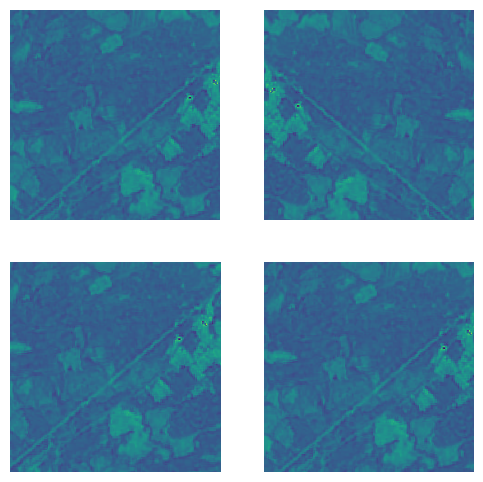

In [16]:
plt.figure(figsize=(6, 6))
for i in range(4):
  rj_inp, rj_re = random_jitter(inp, re)
  plt.subplot(2, 2, i + 1)
  plt.imshow(rj_inp[:,:,0])
  plt.axis('off')
plt.show()

In [17]:
def load_image_train(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = random_jitter(input_image, real_image)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [18]:
def load_image_test(image_file):
  input_image, real_image = load(image_file)
  real_image = imageise_real_image(real_image)

  input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
  input_image, real_image = normalize(input_image, real_image)

  real_image = real_image[:,:,0]

  return input_image, real_image

# def load_image_test(image_file):
#   input_image, real_image = load(image_file)
#   input_images = imageise_input_image(input_image)
#   temp = []
#   for image in input_images:
#     temp.append(resize_one(image, IMG_HEIGHT, IMG_WIDTH))
#   input_image = tf.stack(temp, axis=2)[:,:,:,0]
#   real_image = imageise_real_image(real_image)
#   real_image = resize_one(real_image, IMG_HEIGHT, IMG_WIDTH)
#   real_image = real_image[:,:,0]
#
#   input_image, real_image = normalize(input_image, real_image)
#
#   return input_image, real_image

In [19]:
train_dataset = tf.data.Dataset.list_files(str(f'{PATH_TRAIN}/*.jpg'))
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

load


In [20]:
try:
  test_dataset = tf.data.Dataset.list_files(str(f'{PATH_VAL}/*.jpg'))
except tf.errors.InvalidArgumentError:
  test_dataset = tf.data.Dataset.list_files(str(f'{PATH_TRAIN}/*.jpg'))
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

load


In [21]:
OUTPUT_CHANNELS = 1

In [22]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [23]:
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(inp, 0))
print (down_result.shape)

(1, 128, 128, 3)


In [24]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [25]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 256, 256, 3)


In [26]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[256, 256, 3])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(128, 4),  # (batch_size, 64, 64, 128)
    downsample(256, 4),  # (batch_size, 32, 32, 256)
    downsample(512, 4),  # (batch_size, 16, 16, 512)
    downsample(512, 4),  # (batch_size, 8, 8, 512)
    downsample(512, 4),  # (batch_size, 4, 4, 512)
    downsample(512, 4),  # (batch_size, 2, 2, 512)
    downsample(512, 4),  # (batch_size, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512, 4),  # (batch_size, 16, 16, 1024)
    upsample(256, 4),  # (batch_size, 32, 32, 512)
    upsample(128, 4),  # (batch_size, 64, 64, 256)
    upsample(64, 4),  # (batch_size, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

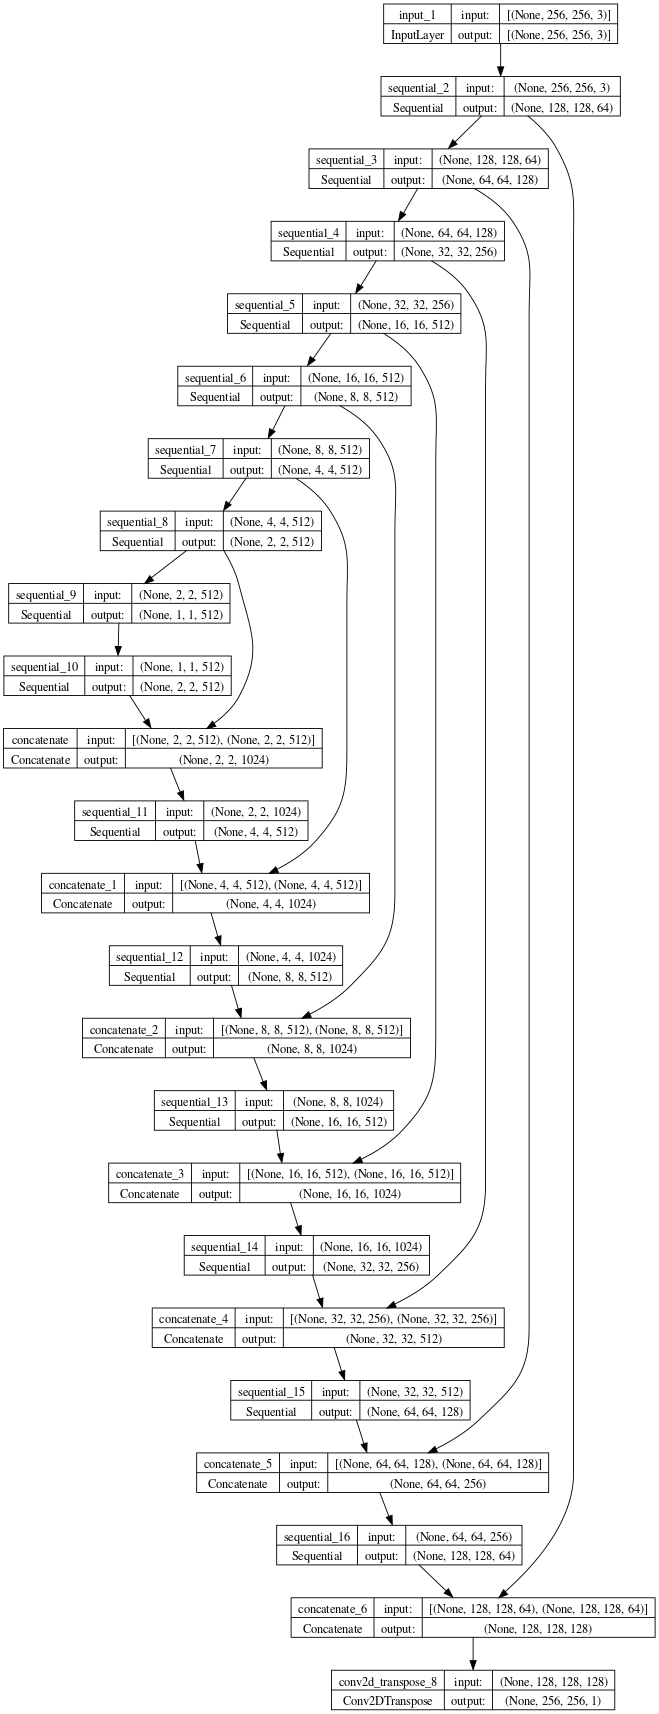

In [27]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

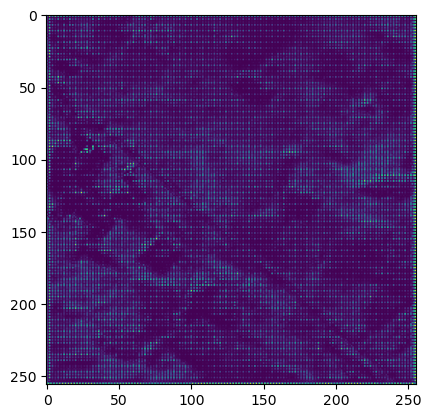

In [30]:
gen_output = generator(inp[tf.newaxis, ...], training=False)
plt.imshow(gen_output[0, ...][:,:,0])

In [31]:
LAMBDA = 100

In [32]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [33]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # Mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
  rmse_loss = tf.reduce_mean((target - gen_output) ** 2) ** 1/2

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss, rmse_loss

In [34]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 256, 1], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
  down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
  down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

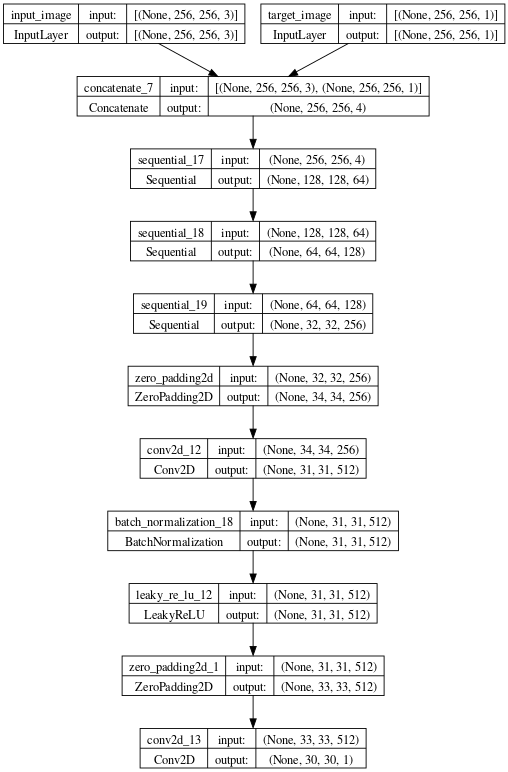

In [35]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

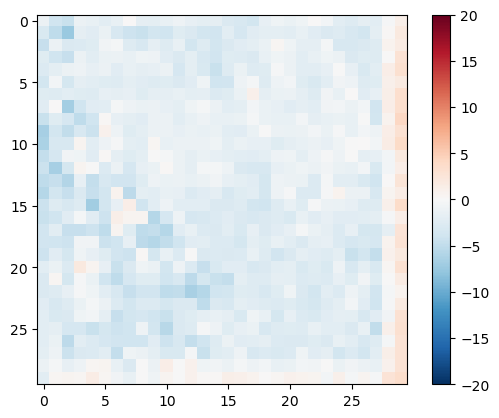

In [36]:
disc_out = discriminator([inp[tf.newaxis, ...], gen_output], training=False)
plt.imshow(disc_out[0, ..., -1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

In [37]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

In [38]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [39]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [40]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(20, 15))

  display_list = [test_input[0], tar[0], prediction[0]]

  fig = plt.figure()
  fig.set_figheight(15)
  fig.set_figwidth(15)

  ax1 = plt.subplot2grid(shape=(9, 9), loc=(0, 0))
  ax2 = plt.subplot2grid(shape=(9, 9), loc=(0, 1))
  ax3 = plt.subplot2grid(shape=(9, 9), loc=(0, 2))
  ax4 = plt.subplot2grid(shape=(9, 9), loc=(1, 0))
  ax5 = plt.subplot2grid(shape=(9, 9), loc=(1, 1))
  ax6 = plt.subplot2grid(shape=(9, 9), loc=(1, 2))
  ax7 = plt.subplot2grid(shape=(9, 9), loc=(2, 0))
  ax8 = plt.subplot2grid(shape=(9, 9), loc=(2, 1))
  ax9 = plt.subplot2grid(shape=(9, 9), loc=(2, 2))

  ax_real = plt.subplot2grid(shape=(9, 9), loc=(0, 3), colspan=3, rowspan=3)
  ax_generated = plt.subplot2grid(shape=(9, 9), loc=(0, 6), colspan=3, rowspan=3)


  # plotting Input images
  ax1.imshow(display_list[0][:,:,0] * 0.5 + 0.5)
  ax2.imshow(display_list[0][:,:,1] * 0.5 + 0.5)
  ax3.imshow(display_list[0][:,:,2] * 0.5 + 0.5)

  ax2.set_title('Input Images')
  ax1.axis('off')
  ax2.axis('off')
  ax3.axis('off')
  ax4.axis('off')
  ax5.axis('off')
  ax6.axis('off')
  ax7.axis('off')
  ax8.axis('off')
  ax9.axis('off')

  ax_real.imshow(display_list[1])
  ax_real.set_title('Ground Truth')
  ax_real.axis('off')

  ax_generated.imshow(display_list[2][:,:,0])
  ax_generated.set_title('Predicted Image')
  ax_generated.axis('off')

  # automatically adjust padding horizontally
  # as well as vertically.
  plt.tight_layout()
  # display plot
  plt.show()


<Figure size 2000x1500 with 0 Axes>

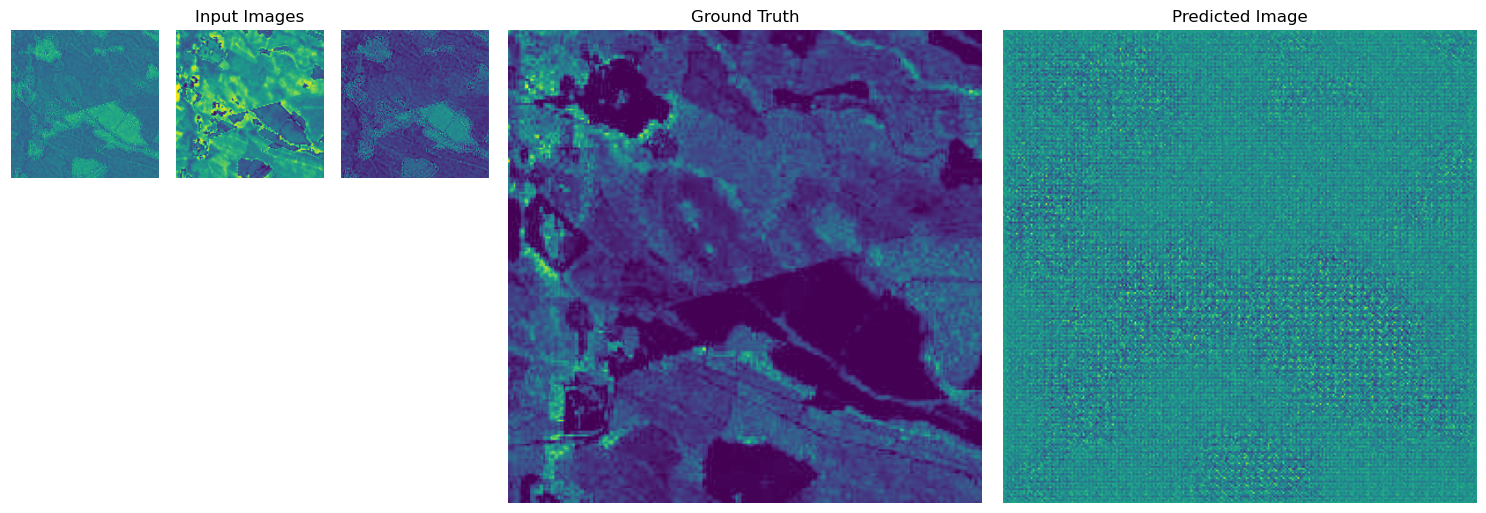

In [41]:
for example_input, example_target in test_dataset.take(1):
  generate_images(generator, example_input, example_target)

In [42]:
log_dir="logs_5e/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [43]:
@tf.function
def train_step(input_image, target, step):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss, gen_rmse_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
    tf.summary.scalar('gen_rmse_loss', gen_rmse_loss, step=step//1000)
    tf.summary.scalar('disc_loss', disc_loss, step=step//1000)

In [44]:
def fit(train_ds, test_ds, steps):
  example_input, example_target = next(iter(test_ds.take(1)))
  start = time.time()

  for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
    if (step) % 1000 == 0:
      # display.clear_output(wait=True)

      if step != 0:
        print(f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')

      start = time.time()

      generate_images(generator, example_input, example_target)
      print(f"Step: {step//1000}k")

    train_step(input_image, target, step)

    # Training step
    if (step+1) % 10 == 0:
      print('.', end='', flush=True)

    # Save (checkpoint) the model every 5k steps
    if (step + 1) % 5000 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

2023-06-20 11:07:48.386230: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization


<Figure size 2000x1500 with 0 Axes>

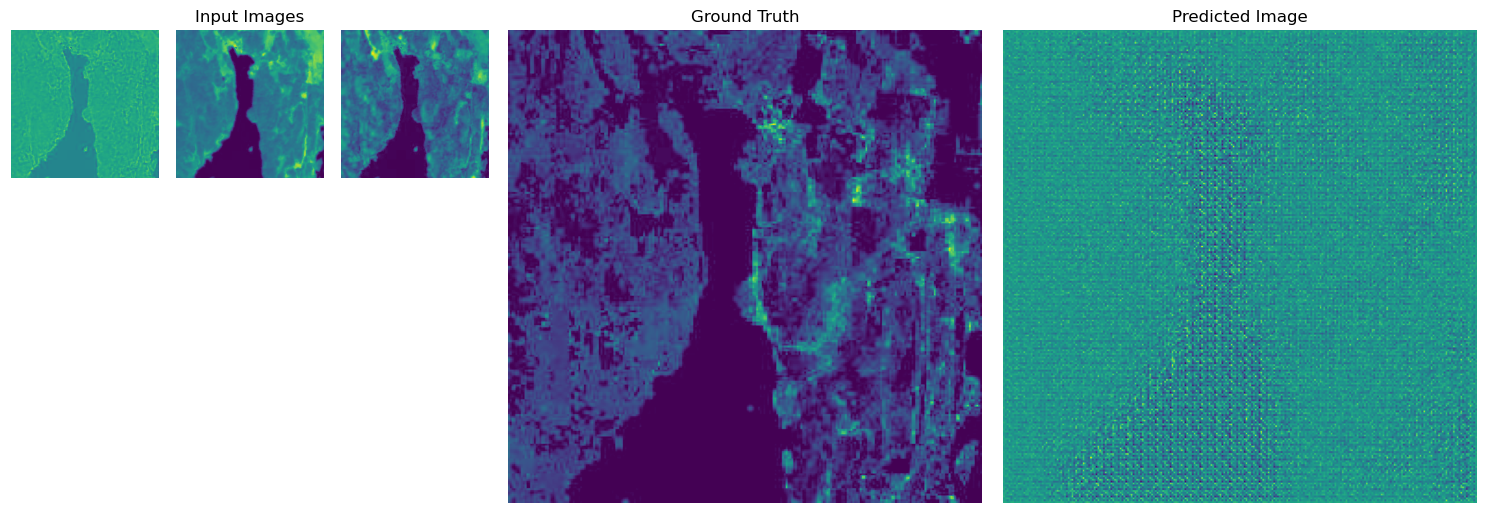

Step: 0k
....................................................................................................Time taken for 1000 steps: 356.79 sec



<Figure size 2000x1500 with 0 Axes>

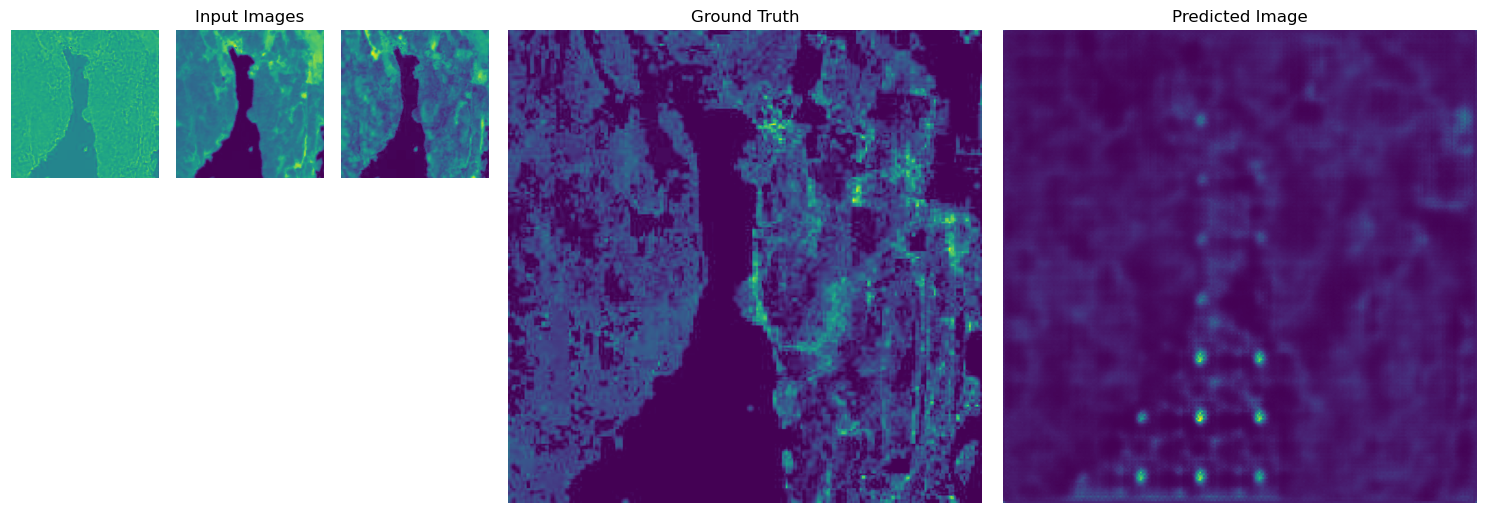

Step: 1k
....................................................................................................Time taken for 1000 steps: 351.97 sec



<Figure size 2000x1500 with 0 Axes>

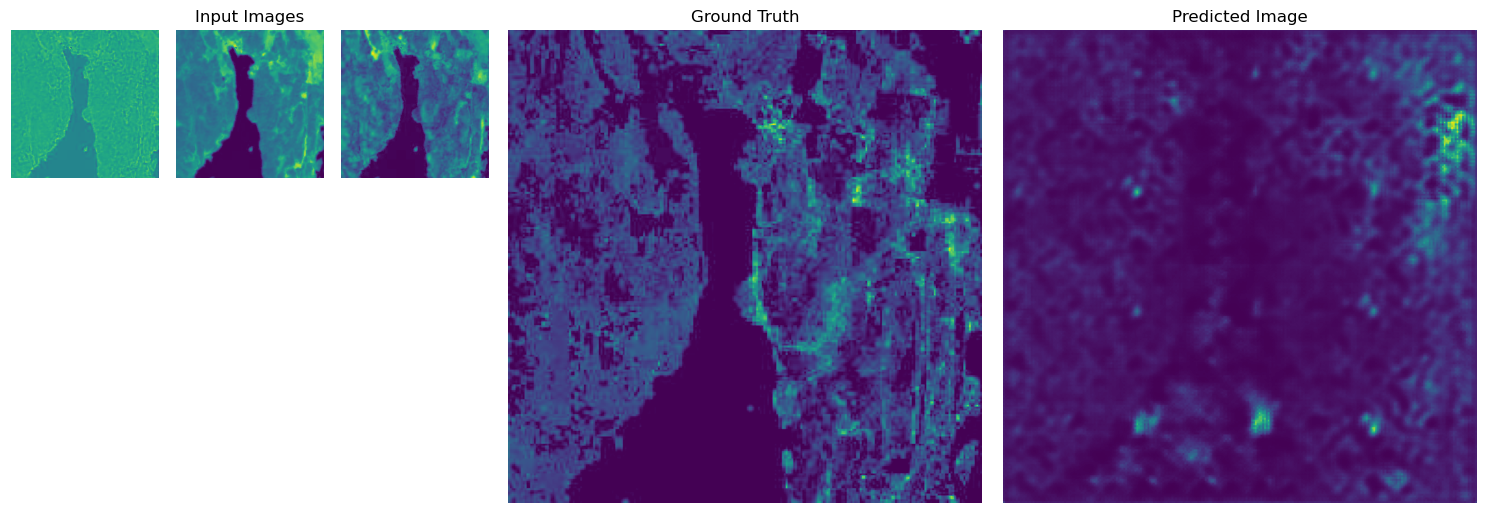

Step: 2k
.......................

KeyboardInterrupt: 

In [45]:
fit(train_dataset, test_dataset, steps=40000)

In [ ]:
log_dir="logs_5e/"
!tensorboard dev upload --logdir {log_dir}


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

logs_5e/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) y

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=c9m9QX7r4buT6eba3BtR61K6DJdMOL&prompt=consent&access_type=offline
Enter 